In [35]:
import pickle
from scipy.special import softmax
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from collections import Counter
from tqdm import tqdm

pickle_location = 'ast-finetuned-audioset-10-10-0.4593-bs8-lr5e-06/checkpoint-24000/logits_labels.pkl'

# Open the file in binary read mode
with open(pickle_location, 'rb') as file:
    # Load the data using pickle
    data = pickle.load(file)

logits = data['logits'][0]
labels = data['labels'][0]
id2label = data['id2label']
label2id = {}
for key, val in id2label.items(): label2id[val] = key

print('id2label: ', id2label)

prob = softmax(logits, axis=-1)
pred = np.argmax(logits, axis=-1)

print('MultiClass:')
precision = precision_score(labels, pred, average='macro', zero_division=1)
print(f"Precision: {precision}")
recall = recall_score(labels, pred, average='macro')
print(f"Recall: {recall}")
f1 = f1_score(labels, pred, average='macro')
print(f"F1 Score: {f1}")

roc_auc = roc_auc_score(labels, prob, average='macro', multi_class='ovr')

print(f"ROC AUC: {roc_auc}")

print()
print('MultiLabel:')


labels_onehot = label_binarize(labels, classes=np.arange(logits.shape[1]))
thres = 0.5
prob_threshed = (prob > thres).astype(int)

# Multi-label metrics
precision = precision_score(labels_onehot, prob_threshed, average='macro', zero_division=1)
print(f"Precision: {precision}")
recall = recall_score(labels_onehot, prob_threshed, average='macro')
print(f"Recall: {recall}")
f1 = f1_score(labels_onehot, prob_threshed, average='macro')
print(f"F1 Score: {f1}")
roc_auc = roc_auc_score(labels_onehot, prob, average='macro', multi_class='ovr')
print(f"ROC AUC: {roc_auc}")

id2label:  {'0': 'amabaw1', '1': 'amapyo1', '2': 'astgna1', '3': 'baffal1', '4': 'barant1', '5': 'bartin2', '6': 'batman1', '7': 'blacar1', '8': 'blbthr1', '9': 'blcbec1', '10': 'blctro1', '11': 'blfant1', '12': 'blfcot1', '13': 'blfjac1', '14': 'blfnun1', '15': 'blgdov1', '16': 'blhpar1', '17': 'bltant2', '18': 'blttro1', '19': 'bobfly1', '20': 'brratt1', '21': 'bsbeye1', '22': 'btfgle1', '23': 'bubgro2', '24': 'bubwre1', '25': 'bucmot4', '26': 'buffal1', '27': 'butsal1', '28': 'butwoo1', '29': 'chwfog1', '30': 'cinmou1', '31': 'cintin1', '32': 'citwoo1', '33': 'coffal1', '34': 'coltro1', '35': 'compot1', '36': 'cowpar1', '37': 'crfgle1', '38': 'ducatt1', '39': 'ducfly', '40': 'ducgre1', '41': 'duhpar', '42': 'dutant2', '43': 'elewoo1', '44': 'eulfly1', '45': 'fasant1', '46': 'fepowl', '47': 'forela1', '48': 'garkin1', '49': 'gilbar1', '50': 'gnbtro1', '51': 'gocspa1', '52': 'goeant1', '53': 'gogwoo1', '54': 'gramou1', '55': 'grasal3', '56': 'grcfly1', '57': 'greant1', '58': 'greibi1'

In [36]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, roc_auc = dict(), dict(), dict()

n_classes = logits.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_onehot[:, i], prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 10000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

class_auc = []

for i in range(n_classes):
    class_auc.append((id2label[str(i)], auc(fpr_grid, np.interp(fpr_grid, fpr[i], tpr[i]))))
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
class_auc.sort(key = lambda a: a[1], reverse=True) 
for cls, area in class_auc:
    print(f'AUC for class {cls}: {area}')


# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print()
print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']}")

AUC for class stwqua1: 0.9961352814316907
AUC for class cowpar1: 0.9960697534459767
AUC for class partan1: 0.9955072200609757
AUC for class baffal1: 0.995217496752325
AUC for class spigua1: 0.9918083723443877
AUC for class meapar: 0.9914634281968816
AUC for class horscr1: 0.9888650811246384
AUC for class rebmac2: 0.9887692810840963
AUC for class whttou1: 0.988342442580943
AUC for class tabsco1: 0.9879484078744342
AUC for class gycwor1: 0.9875924968835234
AUC for class muswre2: 0.9874161784264115
AUC for class grcfly1: 0.9867358584913403
AUC for class blfjac1: 0.9849667303325397
AUC for class whbtot1: 0.9846553278592659
AUC for class pluant1: 0.9836545695532274
AUC for class blfnun1: 0.9829008097628905
AUC for class butsal1: 0.9790921110871341
AUC for class whcspa1: 0.9777101260615021
AUC for class gocspa1: 0.9769184916709268
AUC for class duhpar: 0.9766008259190887
AUC for class blhpar1: 0.9765396144885063
AUC for class yetwoo2: 0.9763779056866722
AUC for class scrpih1: 0.9761157807794

In [37]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_onehot.ravel(), prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9596891618263059


112
97


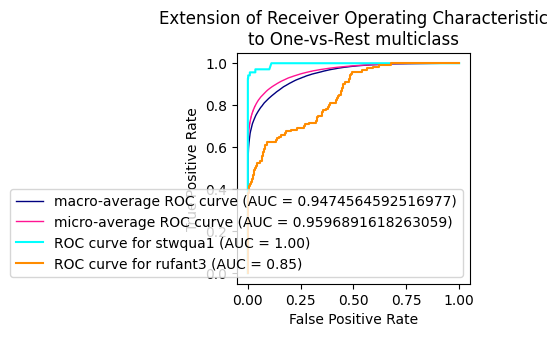

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']})",
    color="navy",
    linewidth=1,
)

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']})",
    color="deeppink",
    linewidth=1,
)

for class_id, color in zip(["stwqua1", "rufant3"], ["aqua", "darkorange"]):
    class_id = int(label2id[class_id])
    print(class_id)
    RocCurveDisplay.from_predictions(
        labels_onehot[:, class_id],
        prob[:, class_id],
        name=f"ROC curve for {id2label[str(class_id)]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)